In [1]:
# Setup: select uncertainty measures and in-distribution dataset
import os
import json
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from typing import List, Dict

import sys
sys.path.insert(0, '../')
from mdu.eval.eval_utils import load_pickle
from mdu.data.constants import DatasetName
from mdu.data.data_utils import split_dataset_indices
from mdu.unc.constants import VectorQuantileModel
from mdu.unc.multidimensional_uncertainty import MultiDimensionalUncertainty
from mdu.randomness import set_all_seeds

# Optional plotting deps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Reproducibility
seed = 42
set_all_seeds(seed)

# Choose your measures: import any preset from configs like in main_images_ood.py
from configs.uncertainty_measures_configs import (
    ADDITIVE_TOTALS,
    BAYES_RISK_AND_BAYES_RISK,
    EXCESSES_DIFFERENT_INSTANTIATIONS,
    EXCESSES_DIFFERENT_APPROXIMATIONS_LOGSCORE,
    EXCESSES_DIFFERENT_APPROXIMATIONS_BRIERSCORE,
    EXCESSES_DIFFERENT_APPROXIMATIONS_SPHERICALSCORE,
    EXCESSES_DIFFERENT_APPROXIMATIONS_ZERO_ONE_SCORE,
    BAYES_DIFFERENT_APPROXIMATIONS_LOGSCORE,
    BAYES_DIFFERENT_APPROXIMATIONS_SPHERICALSCORE,
    SINGLE_MEASURE,
)

# === USER CONFIGURATION ===
# Pick which list of uncertainty measures to use
UNCERTAINTY_MEASURES = BAYES_DIFFERENT_APPROXIMATIONS_LOGSCORE  # change as desired

# Pick in-distribution dataset to evaluate
IND_DATASET = DatasetName.CIFAR100.value  # change as desired

# Multidimensional model and its params (mirrors main_images_ood.py defaults)
MULTIDIM_MODEL = VectorQuantileModel.ENTROPIC_OT

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if MULTIDIM_MODEL == VectorQuantileModel.CPFLOW:
    train_kwargs = {"lr": 1e-4, "num_epochs": 10, "batch_size": 64, "device": device}
    multidim_params = {
        "feature_dimension": len(UNCERTAINTY_MEASURES),
        "hidden_dim": 8,
        "num_hidden_layers": 5,
        "nblocks": 4,
        "zero_softplus": False,
        "softplus_type": "softplus",
        "symm_act_first": False,
    }
elif MULTIDIM_MODEL == VectorQuantileModel.OTCP:
    train_kwargs = {"batch_size": 64, "device": device}
    multidim_params = {"positive": True}
elif MULTIDIM_MODEL == VectorQuantileModel.ENTROPIC_OT:
    train_kwargs = {"batch_size": 64, "device": device}
    multidim_params = {
        "target": "exp",
        "standardize": False,
        "fit_mse_params": False,
        "eps": 0.1,
        "max_iters": 100,
        "tol": 1e-6,
        "random_state": seed,
    }
else:
    raise ValueError(f"Invalid multidim model: {MULTIDIM_MODEL}")

# Ensemble groups (same as scripts)
ENSEMBLE_GROUPS = [
    [0, 1, 2, 3, 4],
    [5, 6, 7, 8, 9],
    [10, 11, 12, 13, 14],
    [15, 16, 17, 18, 19],
]

print(f"Device: {device}")
print(f"Using {len(UNCERTAINTY_MEASURES)} measures: {[m['print_name'] for m in UNCERTAINTY_MEASURES]}")
print(f"In-distribution dataset: {IND_DATASET}")


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All seeds have been set to 42
Device: cuda:0
Using 3 measures: ['B 1', 'B 2', 'B 3']
In-distribution dataset: cifar100


In [2]:
# Helpers: discover OOD datasets and run evaluations via main_images_ood.main
from pathlib import Path
from typing import Tuple
from main_images_ood import main as run_one_ood
from main_images_mis import main as run_one_mis

WEIGHTS_ROOT = Path("../model_weights")


def evaluate_across_oods_and_mis(
    ensemble_groups: list,
    ind_dataset: str,
    ood_datasets: List[str],
    uncertainty_measures: list,
    multidim_model: VectorQuantileModel,
    multidim_params: dict,
    train_kwargs: dict,
    weights_root: str,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Run evaluations for both OOD detection and misclassification detection.
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (ood_results_df, mis_results_df)
    """
    # Run OOD evaluations
    ood_dfs = []
    for ood in ood_datasets:
        print(f"Running OOD evaluation: {ind_dataset} -> {ood}")
        df = run_one_ood(
            ensemble_groups,
            ind_dataset,
            ood,
            uncertainty_measures,
            multidim_model,
            multidim_params,
            train_kwargs,
            weights_root,
            seed=42
        )
        ood_dfs.append(df)
    
    # Run misclassification detection evaluation
    print(f"Running misclassification detection evaluation on {ind_dataset}")
    mis_df = run_one_mis(
        ensemble_groups,
        ind_dataset,
        ind_dataset,
        uncertainty_measures,
        multidim_model,
        multidim_params,
        train_kwargs,
        weights_root,
        seed=42
    )
    
    # Combine OOD results
    if len(ood_dfs) == 0:
        ood_results_df = pd.DataFrame(columns=[
            "In-distribution","Out-of-distribution","Metric","ROC AUC Scores","Mean ROC AUC","Std ROC AUC"
        ])
    else:
        ood_results_df = pd.concat(ood_dfs, ignore_index=True)
    
    return ood_results_df, mis_df


In [3]:
# Discover OOD datasets and run
available_oods = [DatasetName.CIFAR10.value, DatasetName.SVHN.value, DatasetName.TINY_IMAGENET.value, DatasetName.CIFAR10C_5.value]
print(f"Available OOD datasets for {IND_DATASET}: {available_oods}")

ood_results_df, mis_results_df = evaluate_across_oods_and_mis(
    ENSEMBLE_GROUPS,
    IND_DATASET,
    available_oods,
    UNCERTAINTY_MEASURES,
    MULTIDIM_MODEL,
    multidim_params,
    train_kwargs,
    WEIGHTS_ROOT,
)

print("\nSummary of ROC AUCs for OOD detection:")
print(ood_results_df)

print("\nSummary of ROC AUCs for misclassification detection:")
print(mis_results_df)



Available OOD datasets for cifar100: ['cifar10', 'svhn', 'tiny_imagenet', 'cifar10c_5']
Running OOD evaluation: cifar100 -> cifar10
All seeds have been set to 42


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. Y

train_cond_idx.shape: (1000,)
calib_idx.shape: (1800,)
test_idx.shape: (7200,)
For metrics: ['B 1', 'B 2', 'B 3']
Running OOD evaluation: cifar100 -> svhn
All seeds have been set to 42


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. Y

train_cond_idx.shape: (1000,)
calib_idx.shape: (1800,)
test_idx.shape: (7200,)
For metrics: ['B 1', 'B 2', 'B 3']
Running OOD evaluation: cifar100 -> tiny_imagenet
All seeds have been set to 42


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. Y

train_cond_idx.shape: (1000,)
calib_idx.shape: (1800,)
test_idx.shape: (7200,)
For metrics: ['B 1', 'B 2', 'B 3']
Running OOD evaluation: cifar100 -> cifar10c_5
All seeds have been set to 42


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. Y

train_cond_idx.shape: (1000,)
calib_idx.shape: (1800,)
test_idx.shape: (7200,)
For metrics: ['B 1', 'B 2', 'B 3']
Running misclassification detection evaluation on cifar100
All seeds have been set to 42
Ensemble accuracy: 0.7405555555555555


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Ensemble accuracy: 0.7433333333333333


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Ensemble accuracy: 0.7394444444444445


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Ensemble accuracy: 0.7436111111111111


/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


train_cond_idx.shape: (1000,)
calib_idx.shape: (1800,)
test_idx.shape: (7200,)
For metrics: ['B 1', 'B 2', 'B 3']

Summary of ROC AUCs for OOD detection:
   In-distribution Out-of-distribution           Metric  \
0         cifar100             cifar10              B 1   
1         cifar100             cifar10              B 2   
2         cifar100             cifar10              B 3   
3         cifar100             cifar10  multidim_scores   
4         cifar100                svhn              B 1   
5         cifar100                svhn              B 2   
6         cifar100                svhn              B 3   
7         cifar100                svhn  multidim_scores   
8         cifar100       tiny_imagenet              B 1   
9         cifar100       tiny_imagenet              B 2   
10        cifar100       tiny_imagenet              B 3   
11        cifar100       tiny_imagenet  multidim_scores   
12        cifar100          cifar10c_5              B 1   
13        cifar100  

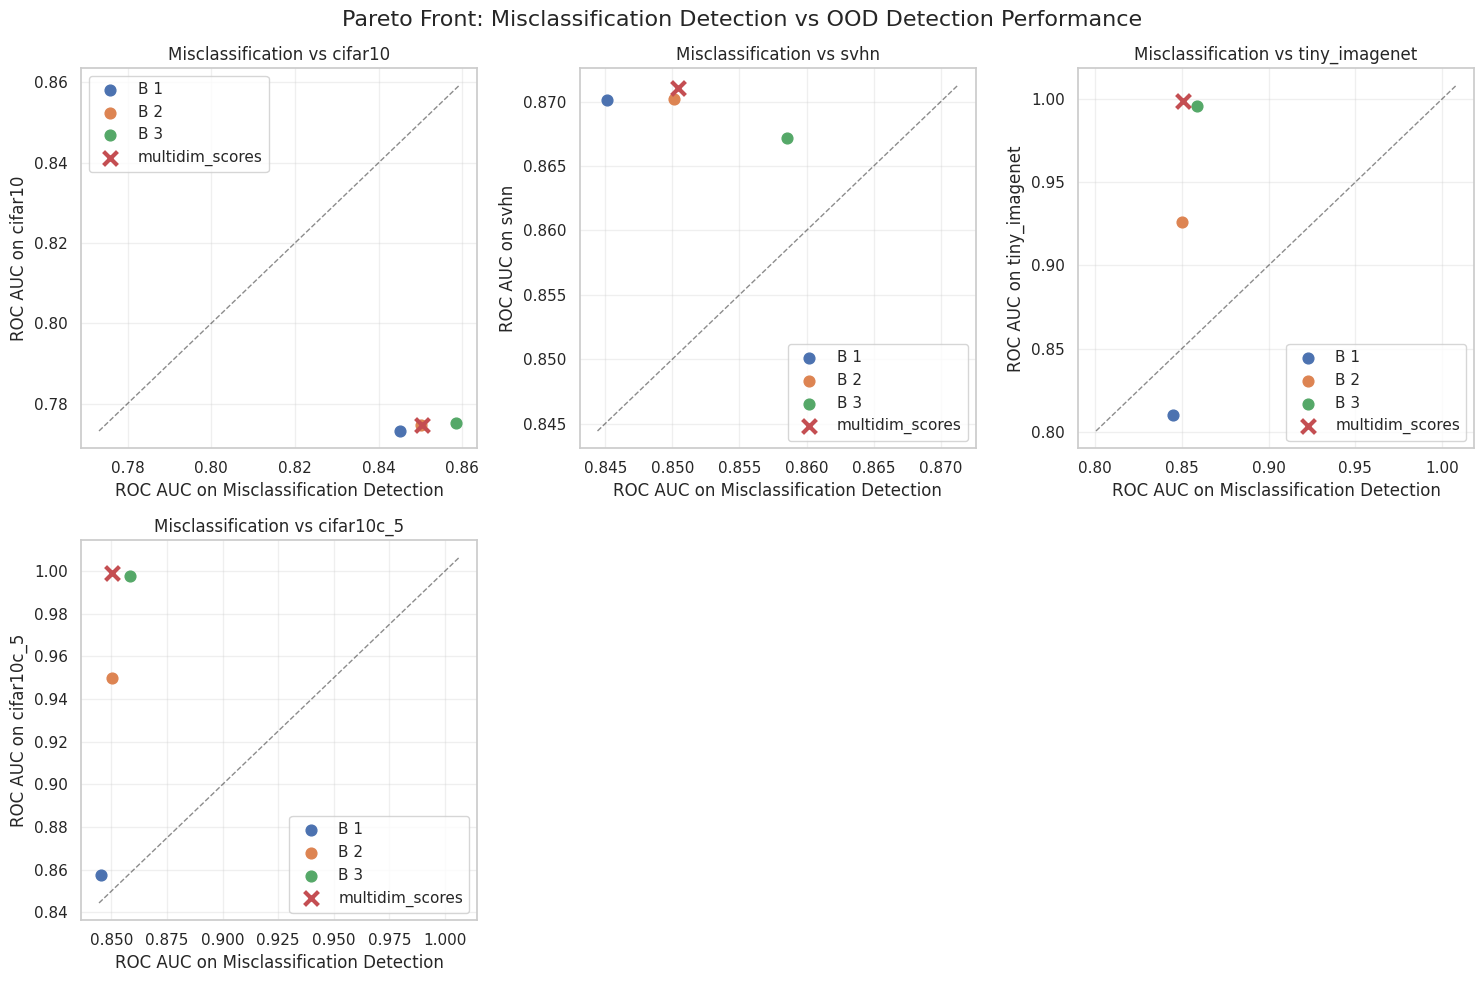

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique OOD datasets and metrics
ood_datasets = ood_results_df['Out-of-distribution'].unique()
ood_metrics = ood_results_df['Metric'].unique()
mis_metrics = mis_results_df['Metric'].unique()

if len(ood_datasets) >= 1:
    # Create scatter plots for misclassification vs each OOD dataset
    n_plots = len(ood_datasets)
    n_cols = min(3, n_plots)  # Max 3 columns
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Handle case where we have only one subplot
    if n_plots == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    for i, ood_dataset in enumerate(ood_datasets):
        ax = axes[i]
        
        # Get data for this OOD dataset
        data_ood = ood_results_df[ood_results_df['Out-of-distribution'] == ood_dataset]
        
        # Plot each metric
        for metric in ood_metrics:
            # Get ROC AUC for this metric on the OOD dataset
            roc_ood = data_ood[data_ood['Metric'] == metric]['Mean ROC AUC'].values
            
            # Get ROC AUC for this metric on misclassification detection
            roc_mis = mis_results_df[mis_results_df['Metric'] == metric]['Mean ROC AUC'].values
            
            if len(roc_ood) > 0 and len(roc_mis) > 0:
                if metric == 'multidim_scores':
                    # Use cross marker for multidim_scores
                    ax.scatter(roc_mis[0], roc_ood[0], marker='x', s=100, label=metric, linewidth=3)
                else:
                    # Use circle marker for other metrics
                    ax.scatter(roc_mis[0], roc_ood[0], marker='o', s=60, label=metric)
        
        ax.set_xlabel('ROC AUC on Misclassification Detection')
        ax.set_ylabel(f'ROC AUC on {ood_dataset}')
        ax.set_title(f'Misclassification vs {ood_dataset}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add diagonal line for reference
        min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1)
    
    # Hide unused subplots
    for j in range(n_plots, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Pareto Front: Misclassification Detection vs OOD Detection Performance', fontsize=16)
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Need at least 1 OOD dataset for Pareto front plot. Found: {len(ood_datasets)}")
